In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff as arf
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Dataset Description

We are using a kidney disease dataset that consits of a persons different biologial paramaters,and if that person has chronoic kidney disease or not. 

We will explore this dataset to see which biological characteristics is indicatory of a person having CKD, and also  explore which parameters has the biggest effect on the diagonosis. From this we will create a model to help predict chronic kidney disease.


# Load functions

These functions converts labels to numbers so they can be used for training the model

In [2]:
def yesno_to_numeric(x):
        if x=='yes': return 1
        if x=='no':   return 0
def normal_to_numeric(x):
        if x=='normal': return 1
        if x=='abnormal':   return 0
def present_to_numeric(x):
        if x=='notpresent': return 1
        if x=='present':   return 0
def good_to_numeric(x):
        if x=='good': return 1
        if x=='poor':   return 0
def ckd_to_numeric(x):
        if x=='ckd': return 1
        if x=='notckd':   return 0

This function replaces na values with the mean.

In [3]:
def fill_with_mean(data):
    for i in range(data.shape[1]):
        mean_value = data[list(data)[i]].mean()
        data[list(data)[i]] = data[list(data)[i]].fillna(mean_value)

KNN model function, it first finds the best K for the model, then trains the model. Returns the trained model.

In [4]:
def k_nearest_neighbor(X_train, y_train, X_test, y_test):
    success_rate = []
    for i in range(1,40):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train,y_train)
        pred_i = knn.predict(X_test)
        success_rate.append(accuracy_score(y_test, pred_i))
    print(success_rate)
    print(max(success_rate))
    print(success_rate.index(max(success_rate)))
    knn = KNeighborsClassifier(n_neighbors=success_rate.index(max(success_rate)))
    knn.fit(X_train,y_train)
    return knn

Gaussian Naive Bayes model function: Trains the model, prints accuracy and returns the trained model.

In [5]:
def gaussian_nbayes(X_train, y_train, X_test, y_test):
    gaussianClassifierNB = GaussianNB()
    gaussianClassifierNB.fit(X_train, y_train)
    predict_y = gaussianClassifierNB.predict(X_test)
    accuracy = accuracy_score(y_test, predict_y)
    print(accuracy)
    return gaussianClassifierNB

Multinomial Naive Bayes model function: Trains the model, prints accuracy and returns the trained model.

In [6]:
def multi_nbayes(X_train, y_train, X_test, y_test):
    multiClassifierNB = MultinomialNB()
    multiClassifierNB.fit(X_train, y_train)
    predict_y = multiClassifierNB.predict(X_test)
    accuracy = accuracy_score(y_test, predict_y)
    print(accuracy)
    return multiClassifierNB

Decision Tree model function: First it find the most accurate depth of the tree. It then trains the model before returning it.

In [7]:
def decision_tree(X_train, y_train, X_test, y_test):
    success_rate = []
    bestAccuracyScore = 0;
    bestDtc = None;
    for i in range(1,40):
        params = {'max_depth': i}
        dtc = DecisionTreeClassifier(**params)
        dtc.fit(X_train,y_train)
        pred_i = dtc.predict(X_test)
        accuracyScore = accuracy_score(y_test, pred_i)
        if accuracyScore > bestAccuracyScore:
            bestAccuracyScore = accuracyScore
            bestDtc = dtc
        success_rate.append(accuracyScore)
    print(success_rate)
    print(max(success_rate))
    print(success_rate.index(max(success_rate))+1)
    #dtc = DecisionTreeClassifier(**{'max_depth': success_rate.index(max(success_rate))+1})
    #dtc.fit(X_train,y_train)
    print(bestDtc.score(X_test, y_test))
    return bestDtc

Function for removing outliers in column that are not the classification column. It removes outliers beyond a distance of 3 standard deviations. It is not used anymore, as we now call "replace_outliers_with_NaN" before calling "fill_with_mean" to replace nan values with mean.

In [8]:
def remove_outliers():
    global data
    factor = 3
    for column in data:
        if column != 'classification':
            
            upper_lim = data[column].mean () + data[column].std () * factor
            lower_lim = data[column].mean () - data[column].std () * factor
            data = data[(data[column] < upper_lim) & (data[column] > lower_lim)]

Function for replacing outliers with NaN values.

In [9]:
def replace_outliers_witnNaN(group, stds):
    group[np.abs(group - group.mean()) > stds * group.std()] = np.nan
    return group

# Load data

Loading data from csv file. Dropping entries where there is no classification as these are useless to us.

In [10]:
unalteredData = pd.read_csv('../data/kidney_disease.csv', sep=',',na_values=['?'], low_memory=False)

In [11]:
unalteredData.dropna(subset=['classification'],inplace=True)
data = unalteredData
header = data['classification']

# Data preparation methods

Looking at the 10 first entries to see how the data looks like

In [12]:
data.head(10)

,id,age,blood pressure,specific gravity,albumin,sugar,red blood cells,pus cell,pus cell clumps,bacteria,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
5,5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
6,6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,...,36.0,NaN,NaN,no,no,no,good,no,no,ckd
7,7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,ckd
8,8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,...,33.0,9600.0,4.0,yes,yes,no,good,no,yes,ckd
9,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd


Here we check to see how many null values there are in the dataset, in order to determine if a column should possibly be dropped if it has too many null values. 

In [13]:
data.isnull().sum()

id                           0
age                          9
blood pressure               9
specific gravity            44
albumin                     43
sugar                       45
red blood cells            142
pus cell                    61
pus cell clumps              4
bacteria                     4
blood glucose random        42
blood urea                  18
serum creatinine            16
sodium                      81
potassium                   82
hemoglobin                  47
packed cell volume          65
white blood cell count      99
red blood cell count       122
hypertension                 2
diabetes mellitus            2
coronary artery disease      2
appetite                     1
pedal edema                  1
anemia                       1
classification               0
dtype: int64

Dropping data where there are many null values.

In [14]:
data = data.drop(['red blood cells','id', 'bacteria '], axis=1)

Converting string values to numeric values so we can train the models

In [15]:
data['hypertension'] = data['hypertension'].apply(yesno_to_numeric)
data['diabetes mellitus'] = data['diabetes mellitus'].apply(yesno_to_numeric)
data['coronary artery disease'] = data['coronary artery disease'].apply(yesno_to_numeric)
data['pedal edema '] = data['pedal edema '].apply(yesno_to_numeric)
data['anemia '] = data['anemia '].apply(yesno_to_numeric)
data['pus cell'] = data['pus cell'].apply(normal_to_numeric)
data['pus cell clumps'] = data['pus cell clumps'].apply(present_to_numeric)
#data['bacteria '] = data['bacteria '].apply(present_to_numeric)
data['appetite'] = data['appetite'].apply(good_to_numeric)
data['classification'] = data['classification'].apply(ckd_to_numeric)

Here we check that all columns have been converted to numeric values.

In [16]:
data.dtypes

age                        float64
blood pressure             float64
specific gravity           float64
albumin                    float64
sugar                      float64
pus cell                   float64
pus cell clumps            float64
blood glucose random       float64
blood urea                 float64
serum creatinine           float64
sodium                     float64
potassium                  float64
hemoglobin                 float64
packed cell volume         float64
white blood cell count     float64
red blood cell count       float64
hypertension               float64
diabetes mellitus          float64
coronary artery disease    float64
appetite                   float64
pedal edema                float64
anemia                     float64
classification               int64
dtype: object

Converting outliers to NaN values.

In [17]:
data.loc[:, data.columns != 'classification'] = data.groupby('classification').transform(lambda g: replace_outliers_witnNaN(g, 3))

Converting NaN values to means.

In [18]:
fill_with_mean(data)

Checking to see if there are any null left

In [19]:
data.isnull().sum()

age                        0
blood pressure             0
specific gravity           0
albumin                    0
sugar                      0
pus cell                   0
pus cell clumps            0
blood glucose random       0
blood urea                 0
serum creatinine           0
sodium                     0
potassium                  0
hemoglobin                 0
packed cell volume         0
white blood cell count     0
red blood cell count       0
hypertension               0
diabetes mellitus          0
coronary artery disease    0
appetite                   0
pedal edema                0
anemia                     0
classification             0
dtype: int64

# Visual Reprensentation

In [20]:
data.describe()

,age,blood pressure,specific gravity,albumin,sugar,pus cell,pus cell clumps,blood glucose random,blood urea,serum creatinine,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,classification
count,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,...,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000
mean,51.625668,75.855615,1.017595,0.985380,0.424332,0.780864,0.892388,145.244118,55.085714,2.694945,...,39.031348,8307.042254,4.706464,0.365535,0.335079,0.088773,0.791667,0.192708,0.153646,0.610390
std,16.383553,11.976127,0.005335,1.263394,0.965985,0.379972,0.308676,69.708297,42.851687,3.343601,...,8.117575,2276.330835,0.830598,0.480952,0.470787,0.284045,0.406116,0.394426,0.360609,0.488296
min,5.000000,50.000000,1.005000,0.000000,0.000000,0.000000,0.000000,22.000000,1.500000,0.400000,...,14.000000,2200.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,70.000000,1.015000,0.000000,0.000000,0.780864,1.000000,101.000000,27.000000,0.900000,...,34.000000,7000.000000,4.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,54.000000,75.855615,1.017595,0.000000,0.000000,1.000000,1.000000,125.000000,44.000000,1.300000,...,39.031348,8307.042254,4.706464,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,64.000000,80.000000,1.020000,2.000000,0.424332,1.000000,1.000000,145.244118,58.000000,2.700000,...,44.000000,9400.000000,5.100000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,90.000000,120.000000,1.025000,5.000000,4.000000,1.000000,1.000000,447.000000,241.000000,24.000000,...,54.000000,19100.000000,6.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
len(data)

385

Here we prepare to find the importance of each column.

In [22]:
corrmat = data.corr()
corrmat

,age,blood pressure,specific gravity,albumin,sugar,pus cell,pus cell clumps,blood glucose random,blood urea,serum creatinine,...,packed cell volume,white blood cell count,red blood cell count,hypertension,diabetes mellitus,coronary artery disease,appetite,pedal edema,anemia,classification
age,1.000000,0.175013,-0.199039,0.130114,0.207357,-0.143962,-0.157860,0.221863,0.194613,0.137719,...,-0.232060,0.117353,-0.224662,0.387214,0.354075,0.244116,-0.153207,0.114079,0.043000,0.247793
blood pressure,0.175013,1.000000,-0.194781,0.161705,0.161614,-0.163859,-0.096476,0.132208,0.193160,0.250653,...,-0.275558,-0.019854,-0.222888,0.255762,0.221943,0.114051,-0.147679,0.029168,0.204808,0.296862
specific gravity,-0.199039,-0.194781,1.000000,-0.461482,-0.304064,0.350174,0.301066,-0.319964,-0.266063,-0.335311,...,0.538916,-0.215054,0.490646,-0.370347,-0.393574,-0.165266,0.262502,-0.284974,-0.232052,-0.698483
albumin,0.130114,0.161705,-0.461482,1.000000,0.288586,-0.564744,-0.415188,0.310197,0.377492,0.391766,...,-0.522921,0.156950,-0.497207,0.475176,0.375729,0.248219,-0.349138,0.447950,0.300128,0.603140
sugar,0.207357,0.161614,-0.304064,0.288586,1.000000,-0.230483,-0.178338,0.560886,0.139700,0.190752,...,-0.205165,0.133577,-0.192045,0.275414,0.475167,0.274214,-0.102768,0.160335,0.081037,0.339695
pus cell,-0.143962,-0.163859,0.350174,-0.564744,-0.230483,1.000000,0.514309,-0.264755,-0.349807,-0.311030,...,0.453605,-0.121384,0.426466,-0.345831,-0.249387,-0.199387,0.295183,-0.386581,-0.306089,-0.433677
pus cell clumps,-0.157860,-0.096476,0.301066,-0.415188,-0.178338,0.514309,1.000000,-0.143583,-0.193732,-0.126931,...,0.276139,-0.144088,0.274884,-0.190424,-0.163388,-0.187776,0.173848,-0.107290,-0.178609,-0.271452
blood glucose random,0.221863,0.132208,-0.319964,0.310197,0.560886,-0.264755,-0.143583,1.000000,0.138127,0.126183,...,-0.275890,0.084185,-0.244785,0.355133,0.493385,0.242216,-0.210201,0.129933,0.085737,0.413379
blood urea,0.194613,0.193160,-0.266063,0.377492,0.139700,-0.349807,-0.193732,0.138127,1.000000,0.736172,...,-0.537924,0.108285,-0.496686,0.433908,0.339614,0.221325,-0.278498,0.283838,0.449204,0.399423
serum creatinine,0.137719,0.250653,-0.335311,0.391766,0.190752,-0.311030,-0.126931,0.126183,0.736172,1.000000,...,-0.517260,0.041767,-0.497905,0.378900,0.318383,0.163378,-0.250500,0.293470,0.453199,0.422313


Here we find the importance of the columns, to find out which column has the biggest influence/impact on the classification

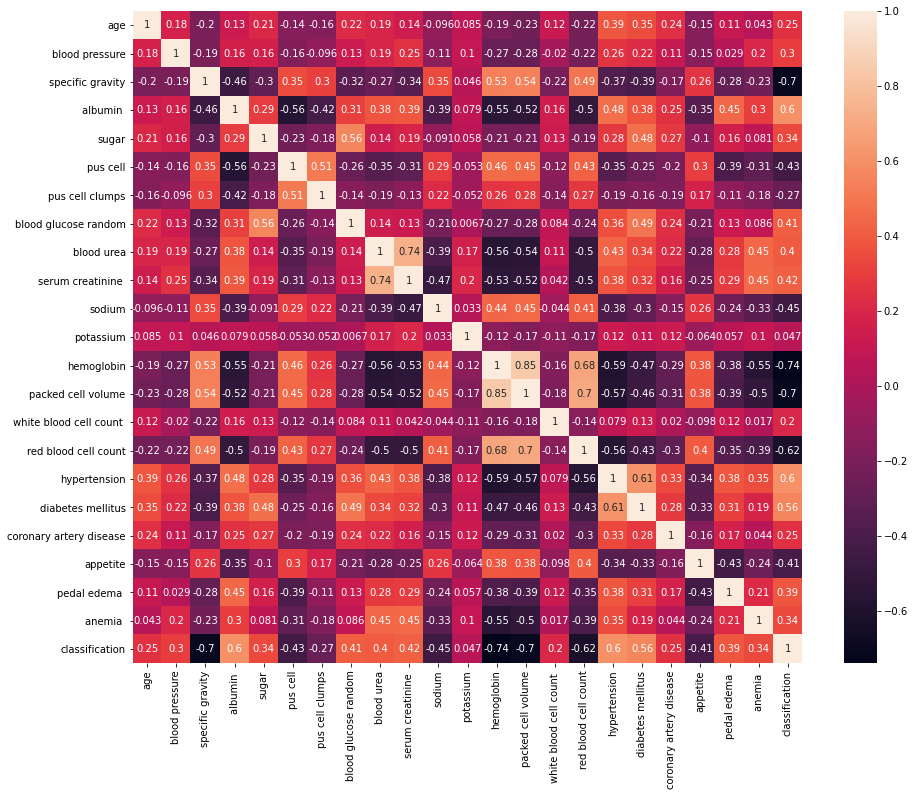

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
sns.heatmap(corrmat, annot=True)
plt.show()

# Heatmap

From this heatmap we can see exacly which biological features that have the biggest impact when diagnosing CKD.

Features that are close to -1 such as hemoglobin, specific gravity and packed cell volumes are important factors when determining if a person does not have CKD.

Features that are close to 1, are features that are important when determining if a person has CKD. These features include hypertension, albium and etc.

Features that are not that important are features that are close to 0, such as age, white blood cell count, blood pressure and other features below 0.40/-0.40. We might remove these features later to try and improve our model.

Here we can see the mean values of patients with or without ckd

In [24]:
kidneyDisease = unalteredData.groupby('classification').mean()
kidneyDisease

,age,blood pressure,specific gravity,albumin,sugar,blood glucose random,blood urea,serum creatinine,sodium,potassium,hemoglobin,packed cell volume,white blood cell count,red blood cell count
classification,,,,,,,,,,,,,,
ckd,54.546256,79.517544,1.014031,1.71066,0.810256,177.457286,73.319283,4.537723,133.833333,4.904430,10.600515,32.729885,9127.972028,3.905000
notckd,46.516779,71.351351,1.022414,0.00000,0.000000,107.722222,32.798611,0.868966,141.731034,4.337931,15.188194,46.335616,7705.594406,5.379021


A bar plot of how old the patients normally are when having or not having ckd.

<AxesSubplot:xlabel='classification'>

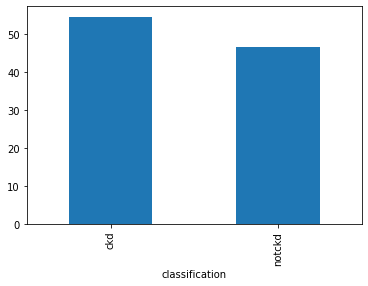

In [25]:
kidneyDisease['age'].plot.bar()

A bar plot of the average values of hemoglobin in patients. The patients who have low hemoglobin values are more likely to have ckd.

<AxesSubplot:xlabel='classification'>

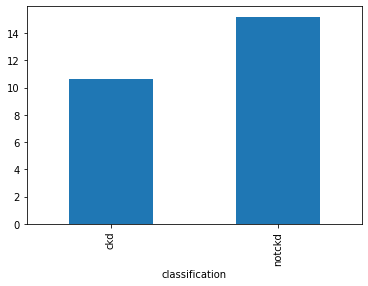

In [26]:
hemoglobin = unalteredData.groupby('classification').mean()
hemoglobin
hemoglobin['hemoglobin'].plot.bar()

Histogram plots of all the values in the dataset, after cleaning. It shows the occurances of values.

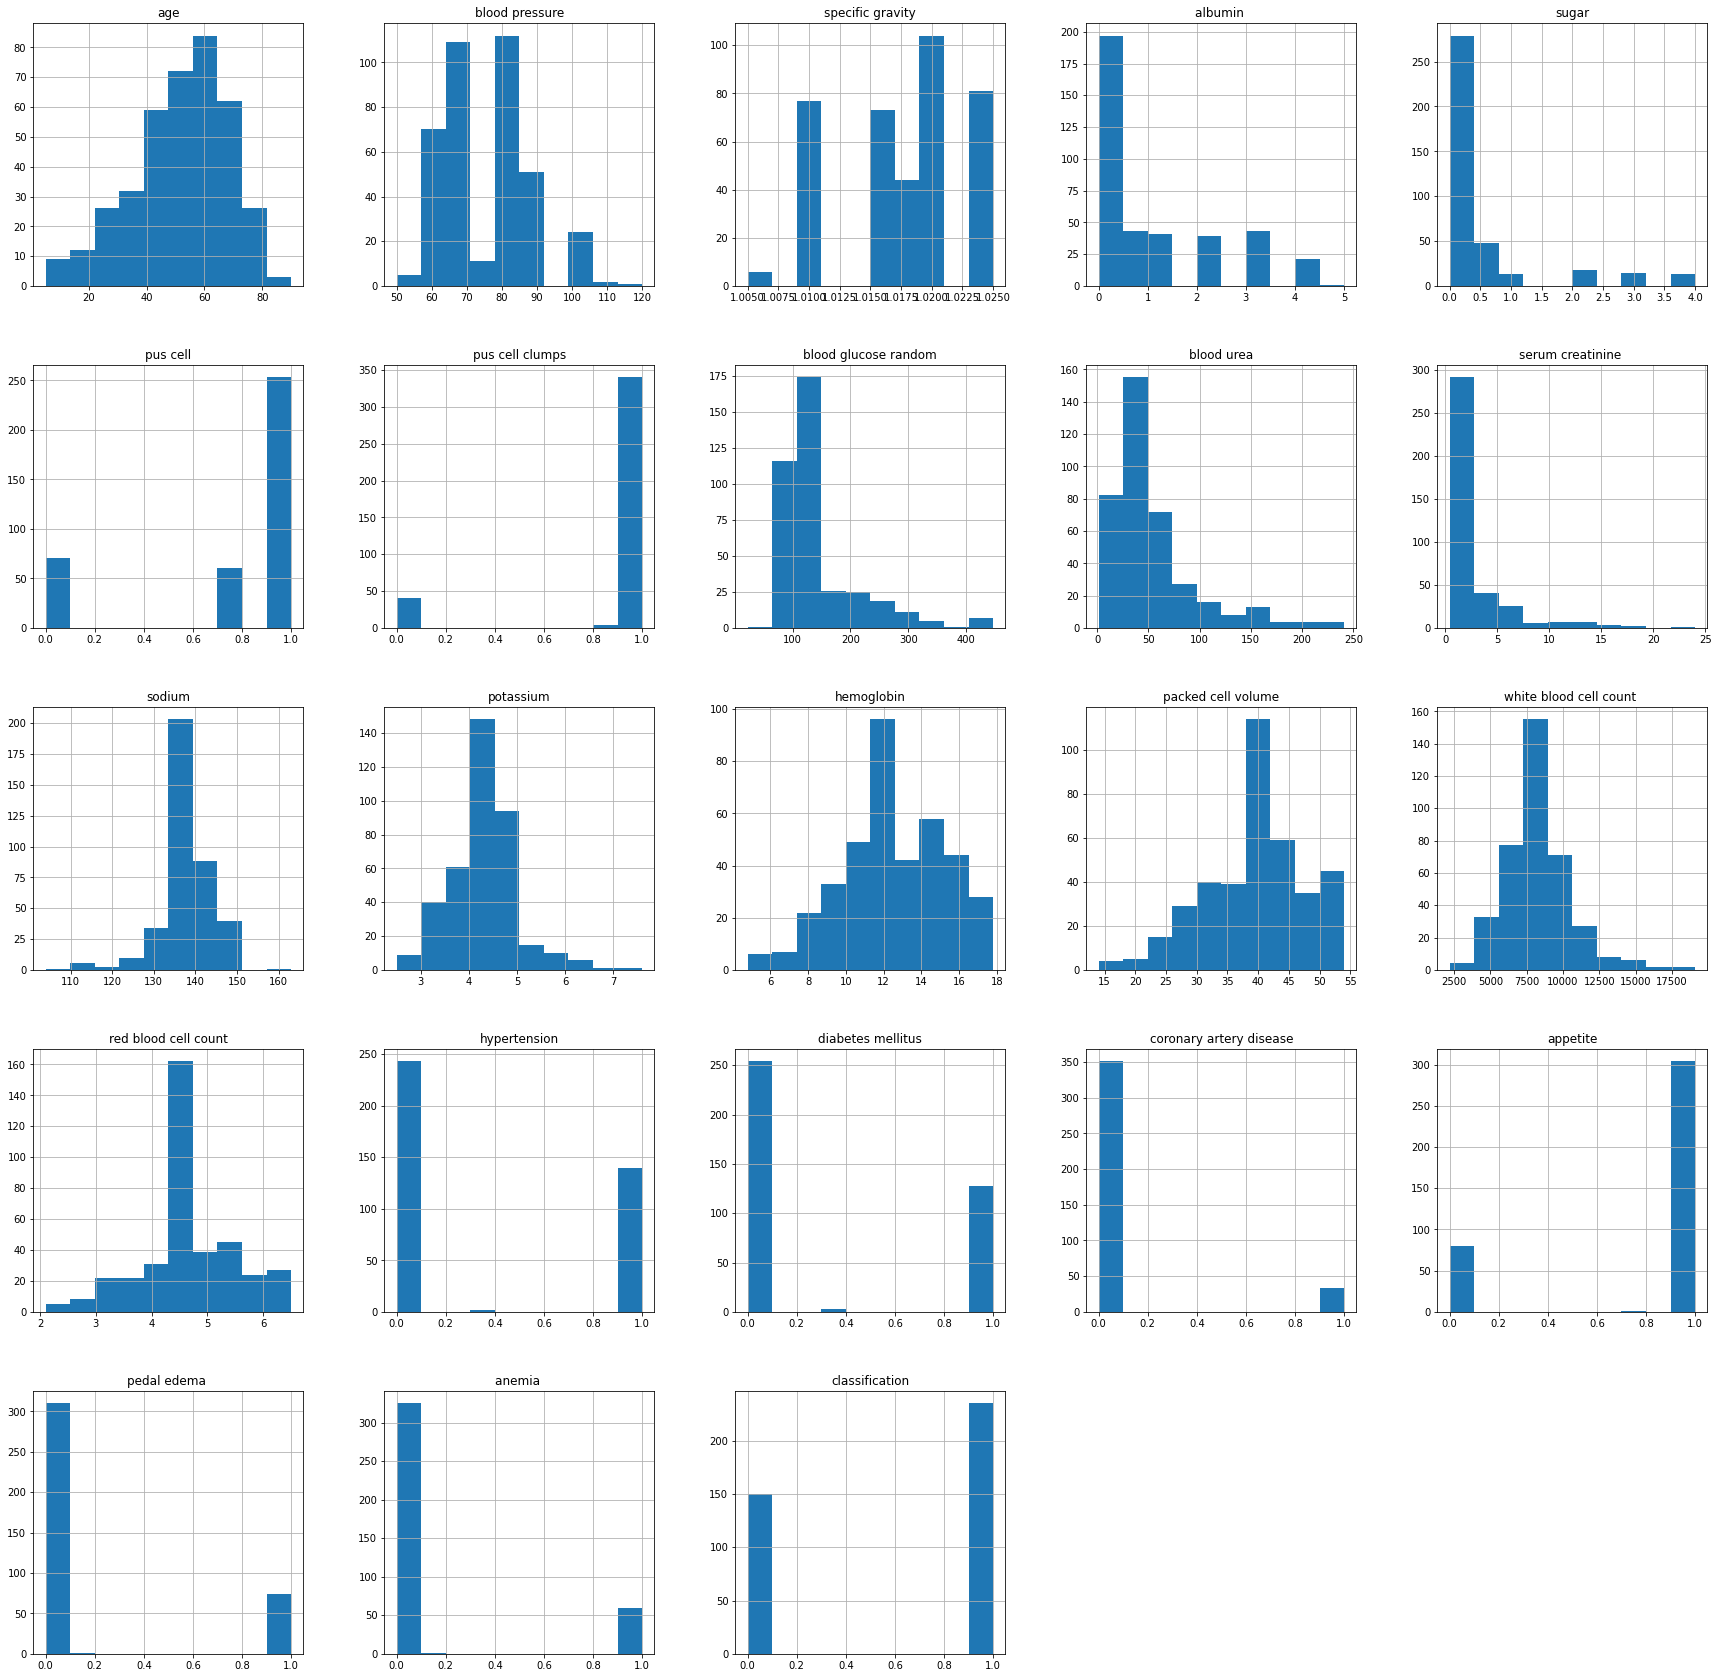

In [27]:
data.hist(figsize=(30,30))
plt.show()

## Histograms on age

A step histogram showing ages of patients.

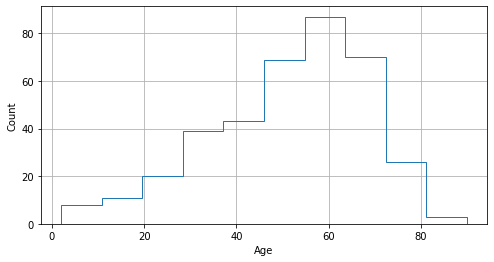

In [28]:
histogramAge = unalteredData['age'].hist(figsize=(8,4),histtype = 'step')
histogramAge.set_xlabel("Age")
histogramAge.set_ylabel("Count")
plt.show()

A new dataset from only the age and classification columns are used to create a dataframe that can be sorted through to create another two dataframes containing only entries containing classification values of respectively 0 and 1.

In [29]:
new_CKD_AGE_Data = data[['age', 'classification']].copy()
# Create DataFrame
new_CKD_AGE_Data = pd.DataFrame(new_CKD_AGE_Data)

# Sort 
m=new_CKD_AGE_Data.classification>=1

df_ageNotCKD=new_CKD_AGE_Data[~m]
df_ageCKD=new_CKD_AGE_Data[m]

A histogram is created to show the distribution of age of CKD-negative patients.

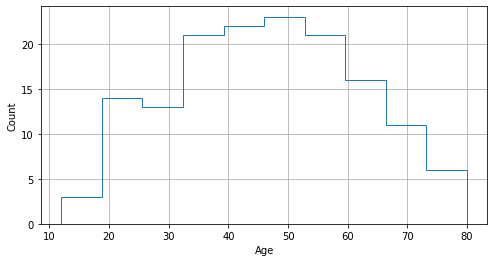

In [30]:
histogramAge = df_ageNotCKD['age'].hist(figsize=(8,4),histtype = 'step')
histogramAge.set_xlabel("Age")
histogramAge.set_ylabel("Count")
plt.show()

A histogram is created to show the distribution of age of CKD-negative patients.

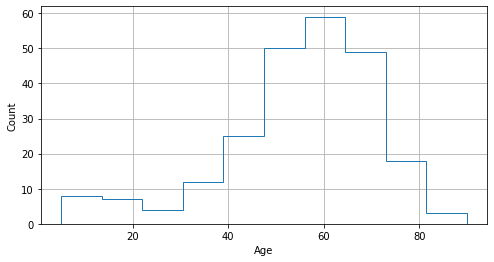

In [31]:
histogramAge = df_ageCKD['age'].hist(figsize=(8,4),histtype = 'step')
histogramAge.set_xlabel("Age")
histogramAge.set_ylabel("Count")
plt.show()

## Histograms on Hemoglobin levels

A step histogram showing the hemoglobin levels of patients.

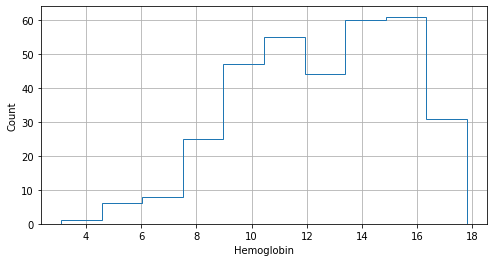

In [32]:
histogramHemo = unalteredData['hemoglobin'].hist(figsize=(8,4),histtype = 'step')
histogramHemo.set_xlabel("Hemoglobin")
histogramHemo.set_ylabel("Count")
plt.show()

A new dataset from only the hemoglobin and classification columns are used to create a dataframe that can be sorted through to create another two dataframes containing only entries containing classification values of respectively 0 and 1.

In [33]:
new_CKD_hemo_Data = data[['hemoglobin', 'classification']].copy()
# Create DataFrame
new_CKD_hemo_Data = pd.DataFrame(new_CKD_hemo_Data)

m=new_CKD_hemo_Data.classification>=1

df_hemoNotCKD=new_CKD_hemo_Data[~m]
df_hemoCKD=new_CKD_hemo_Data[m]

A histogram is created to show the distribution of hemoglobin levels of CKD-negative patients.

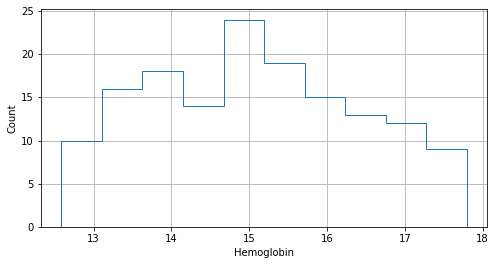

In [34]:
histogramAge = df_hemoNotCKD['hemoglobin'].hist(figsize=(8,4),histtype = 'step')
histogramAge.set_xlabel("Hemoglobin")
histogramAge.set_ylabel("Count")
plt.show()

A histogram is created to show the distribution of hemoglobin levels of CKD-positive patients.

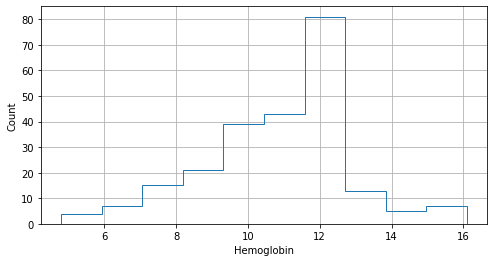

In [35]:
histogramAge = df_hemoCKD['hemoglobin'].hist(figsize=(8,4),histtype = 'step')
histogramAge.set_xlabel("Hemoglobin")
histogramAge.set_ylabel("Count")
plt.show()

# Creating machine learning models

In the code block below we take aside a sample of 25 random entries for later validation and remove them from the main dataset.

In [36]:
df_subset = data.sample(25)
data.drop(df_subset.index)
X_subset = df_subset.drop(['classification'], axis=1)
y_subset = df_subset[['classification']]

Drop the classification header before training, then split the data in training and test 70%/30%

In [37]:
y = data[['classification']]
X = data.drop(['classification'], axis=1)
y = y.values[:,0]
set_prop = 0.3

#  Initialize seed parameter for the random number generator used for the split
seed = 7

# Split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

## Test model with KNN 

Testing the model with KNN classifier

In [38]:
knn_model = k_nearest_neighbor(X_train, y_train, X_test, y_test)

[0.7155172413793104, 0.7413793103448276, 0.6637931034482759, 0.7068965517241379, 0.7327586206896551, 0.7413793103448276, 0.75, 0.7241379310344828, 0.7586206896551724, 0.7327586206896551, 0.7413793103448276, 0.7327586206896551, 0.7155172413793104, 0.7155172413793104, 0.7327586206896551, 0.7241379310344828, 0.7155172413793104, 0.7155172413793104, 0.7155172413793104, 0.7068965517241379, 0.7241379310344828, 0.7413793103448276, 0.6724137931034483, 0.6896551724137931, 0.6896551724137931, 0.7068965517241379, 0.6982758620689655, 0.6982758620689655, 0.6982758620689655, 0.7068965517241379, 0.6810344827586207, 0.6810344827586207, 0.6637931034482759, 0.6724137931034483, 0.6724137931034483, 0.6810344827586207, 0.6637931034482759, 0.6724137931034483, 0.6637931034482759]
0.7586206896551724
8


A score of 0.76 is very bad and can not be used in medical application.

## Test model with Gaussian Naive Bayes

In [39]:
gaussian_model = gaussian_nbayes(X_train, y_train, X_test, y_test)

0.9827586206896551


A score of 0.98 is acceptable.

## Test model with Multinominal Naive Bayes

In [40]:
multi_model = multi_nbayes(X_train, y_train, X_test, y_test)

0.8448275862068966


A score of 0.84 is not good!

## Test model with Decision Tree

In [41]:
decision_model = decision_tree(X_train, y_train, X_test, y_test)

[0.8793103448275862, 0.9741379310344828, 0.9741379310344828, 0.9827586206896551, 0.9482758620689655, 0.9655172413793104, 0.9655172413793104, 0.9827586206896551, 0.9655172413793104, 0.9741379310344828, 0.9741379310344828, 0.9568965517241379, 0.9568965517241379, 0.9741379310344828, 0.9655172413793104, 0.9913793103448276, 0.9568965517241379, 0.9741379310344828, 0.9827586206896551, 0.9655172413793104, 0.9655172413793104, 0.9568965517241379, 0.9568965517241379, 0.9827586206896551, 0.9568965517241379, 0.9741379310344828, 0.9655172413793104, 0.9482758620689655, 0.9655172413793104, 0.9568965517241379, 0.9655172413793104, 0.9741379310344828, 0.9655172413793104, 0.9913793103448276, 0.9827586206896551, 0.9827586206896551, 0.9741379310344828, 0.9741379310344828, 0.9655172413793104]
0.9913793103448276
16
0.9913793103448276


Very good score with 0.99 accuracy!

## Part 2
In this part we want to analyze and improve the models by feature engineering.

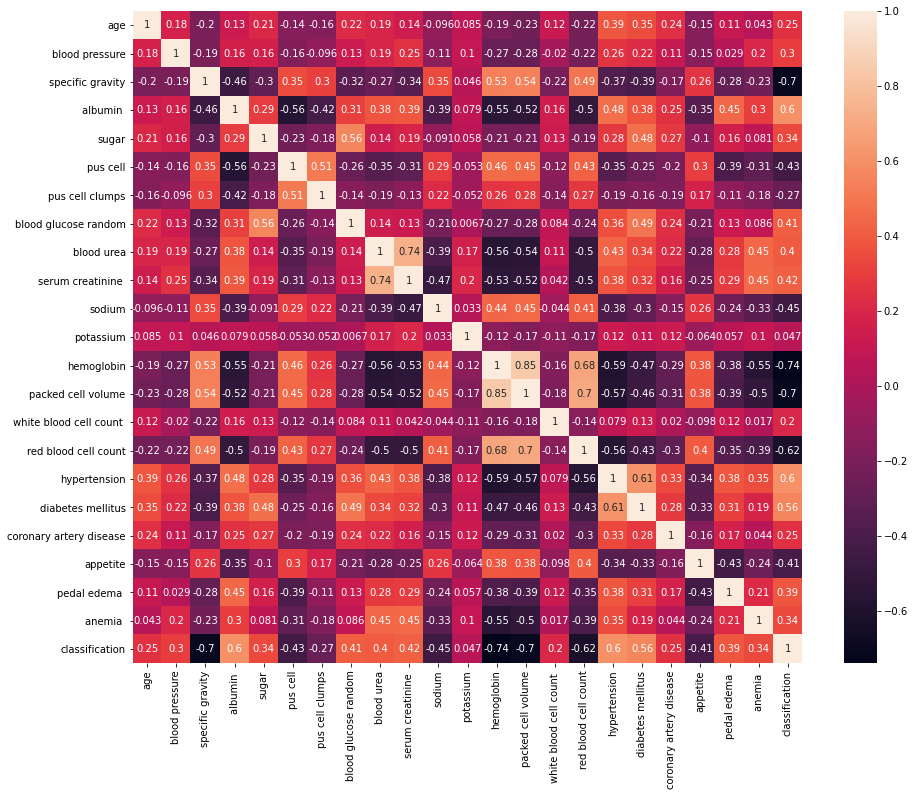

In [42]:
plt.figure(figsize=(15, 12))
sns.heatmap(corrmat, annot=True)
plt.show()

Here we can see the importance again of columns. We decided to remove all columns with importance less than 0.4/-0.4.

In [43]:
X_subset2 = df_subset.drop(['classification', 'age', 'blood pressure', 'sugar', 'pus cell clumps', 'white blood cell count ', 'red blood cell count', 'coronary artery disease', 'pedal edema ', 'anemia '], axis=1)
y_subset2 = df_subset[['classification']]



Here we create a new train/test split without the least important columns.

In [44]:
y = data[['classification']]
X = data.drop(['classification', 'age', 'blood pressure', 'sugar', 'pus cell clumps', 'white blood cell count ', 'red blood cell count', 'coronary artery disease', 'pedal edema ', 'anemia '], axis=1)
y = y.values[:,0]
set_prop = 0.3

#  Initialize seed parameter for the random number generator used for the split
seed = 7

# Split
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

Now we can see a heatmap of the most important columns.

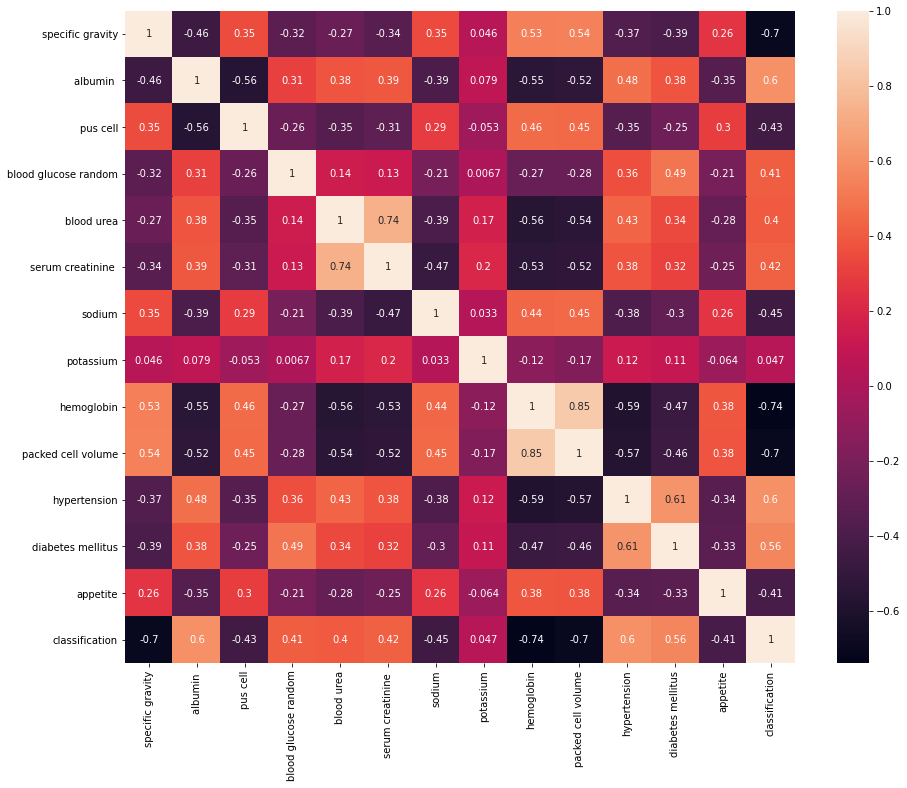

In [45]:
data_drop = data.drop(['age', 'blood pressure', 'sugar', 'pus cell clumps', 'white blood cell count ', 'red blood cell count', 'coronary artery disease', 'pedal edema ', 'anemia '], axis=1)

corrmat_drop = data_drop.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corrmat_drop, annot=True)
plt.show()

Here we train our models again, without the least important columns this time

In [46]:
knn_model2 = k_nearest_neighbor(X_train2, y_train2, X_test2, y_test2)
print(classification_report(y_test2, knn_model2.predict(X_test2)))

[0.8879310344827587, 0.8706896551724138, 0.896551724137931, 0.8706896551724138, 0.8879310344827587, 0.8706896551724138, 0.8793103448275862, 0.8620689655172413, 0.8793103448275862, 0.8706896551724138, 0.8706896551724138, 0.853448275862069, 0.853448275862069, 0.853448275862069, 0.853448275862069, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8448275862068966, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241, 0.8362068965517241]
0.896551724137931
2
              precision    recall  f1-score   support

           0       0.78      0.96      0.86        49
           1       0.96      0.81      0.88        67

    accuracy                           0

Accuracy of 0.87 is still not good enough, but better than before. We want above 0.95!

In [47]:
gaussian_model2 = gaussian_nbayes(X_train2, y_train2, X_test2, y_test2)
print(classification_report(y_test2, gaussian_model2.predict(X_test2)))

0.9655172413793104
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        49
           1       0.97      0.97      0.97        67

    accuracy                           0.97       116
   macro avg       0.96      0.96      0.96       116
weighted avg       0.97      0.97      0.97       116



Accuracy score of 0.97 is worse than before with 0.98, but still acceptable.

In [48]:
multi_model2 = multi_nbayes(X_train2, y_train2, X_test2, y_test2)
print(classification_report(y_test2, multi_model2.predict(X_test2)))

0.853448275862069
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        49
           1       0.96      0.78      0.86        67

    accuracy                           0.85       116
   macro avg       0.86      0.87      0.85       116
weighted avg       0.88      0.85      0.85       116



A slight improvement from 0.84 to 0.85

In [49]:
decision_model2 = decision_tree(X_train2, y_train2, X_test2, y_test2)
print(classification_report(y_test2, decision_model2.predict(X_test2)))

[0.8793103448275862, 0.9655172413793104, 0.9655172413793104, 0.9568965517241379, 0.9741379310344828, 0.9741379310344828, 0.9827586206896551, 0.9655172413793104, 0.9827586206896551, 0.9655172413793104, 0.9741379310344828, 0.9741379310344828, 0.9741379310344828, 0.9568965517241379, 0.9568965517241379, 0.9741379310344828, 0.9827586206896551, 0.9655172413793104, 0.9655172413793104, 0.9655172413793104, 0.9655172413793104, 0.9568965517241379, 0.9568965517241379, 0.9741379310344828, 0.9741379310344828, 0.9827586206896551, 0.9568965517241379, 0.9827586206896551, 0.9568965517241379, 0.9655172413793104, 0.9655172413793104, 0.9741379310344828, 0.9655172413793104, 0.9655172413793104, 0.9568965517241379, 0.9741379310344828, 0.9741379310344828, 0.9655172413793104, 0.9827586206896551]
0.9827586206896551
7
0.9827586206896551
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        49
           1       0.97      1.00      0.99        67

    accuracy   

Decision tree got slightly worse.

# Testing with new data - Random
This turned out bad as we had predicted, as random data doesn't corrolate to the actual data the models are trained on.

In [50]:
#'specific gravity', 'albumin ', 'pus cell', 'blood glucose random', 'blood urea', 'serum creatinine ', 'sodium', 'potassium', 'hemoglobin', 'packed cell volume', 'hypertension', 'diabetes mellitus', 'appetite'


data_random = pd.DataFrame({'specific gravity' : np.round(np.random.uniform(min(data['specific gravity']), max(data['specific gravity']), size=10), 3), 
                            'albumin ' : np.random.randint(min(data['albumin ']), max(data['albumin '])+1, size=10),
                            'pus cell' : np.random.randint(min(data['pus cell']), max(data['pus cell'])+1, size=10),
                            'blood glucose random' : np.random.randint(min(data['blood glucose random']), max(data['blood glucose random'])+1, size=10),
                            'blood urea' : np.round(np.random.uniform(min(data['blood urea']), max(data['blood urea']), size=10), 1),
                            'serum creatinine ' : np.round(np.random.uniform(min(data['serum creatinine ']), max(data['serum creatinine ']), size=10), 1),
                            'sodium' : np.random.randint(min(data['sodium']), max(data['sodium'])+1, size=10),
                            'potassium' : np.round(np.random.uniform(min(data['potassium']), max(data['potassium']), size=10), 1),
                            'hemoglobin' : np.round(np.random.uniform(min(data['hemoglobin']), max(data['hemoglobin']), size=10), 1),
                            'packed cell volume' : np.random.randint(min(data['packed cell volume']), max(data['packed cell volume'])+1, size=10),
                            'hypertension' : np.random.randint(min(data['hypertension']), max(data['hypertension'])+1, size=10),
                            'diabetes mellitus' : np.random.randint(min(data['diabetes mellitus']), max(data['diabetes mellitus'])+1, size=10),
                            'appetite' : np.random.randint(min(data['appetite']), max(data['appetite'])+1, size=10)})

In [51]:
data_random
#print(min(data['pus cell']))
#print(max(data['pus cell']))

,specific gravity,albumin,pus cell,blood glucose random,blood urea,serum creatinine,sodium,potassium,hemoglobin,packed cell volume,hypertension,diabetes mellitus,appetite
0,1.006,0,1,309,110.4,20.2,157,3.7,15.8,54,0,0,1
1,1.010,2,1,394,83.4,4.0,156,2.8,11.1,17,1,0,1
2,1.018,4,0,216,199.5,17.3,106,7.2,12.1,31,0,0,0
3,1.009,0,1,383,138.4,17.7,105,5.3,7.3,50,0,0,1
4,1.020,3,1,445,220.2,12.7,129,3.7,5.3,31,1,0,0
5,1.009,5,1,193,173.7,9.8,117,6.7,10.0,15,0,1,1
6,1.018,3,1,63,155.4,8.4,148,3.5,10.1,14,1,1,0
7,1.012,3,0,52,162.2,8.2,124,5.8,9.1,36,1,1,1
8,1.005,2,0,37,20.9,9.5,108,4.6,12.6,54,0,0,1
9,1.023,5,0,350,19.2,13.3,119,7.0,12.2,20,1,0,0


In [52]:
np.round(np.random.uniform(min(data['potassium']), max(data['potassium']), size=10), 1)

array([5.2, 3.5, 4.5, 6.5, 7.5, 6.1, 5.9, 6.6, 2.9, 7.6])

# Testing with new data : sample

Here we test our first models on the dataset with all columns included against the sample of 25 we set aside earlier.

In [53]:
print(knn_model.predict(X_subset))
print(accuracy_score(y_subset, knn_model.predict(X_subset)))

[0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0]
0.52


KNN has a very bad score, and is not reliable.

In [54]:
print(gaussian_model.predict(X_subset))
print(accuracy_score(y_subset, gaussian_model.predict(X_subset)))

[1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1]
0.92


Gaussian Naive Bayes: is also a good score, though missing a few.

In [55]:
print(multi_model.predict(X_subset))
print(accuracy_score(y_subset, multi_model.predict(X_subset)))

[1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0]
0.68


Multinomial Naive Bayes: is not good at all at prediction the y_subset.

In [56]:
print(decision_model.predict(X_subset))
print(accuracy_score(y_subset, decision_model.predict(X_subset)))

[1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1]
1.0


Decision tree is able to predict all of them!

Then we test our new models with the dataset with least important columns removed against the sample of 25 we set aside earlier. 

In [57]:
print(knn_model2.predict(X_subset2))
print(accuracy_score(y_subset2, knn_model2.predict(X_subset2)))

[1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1]
0.88


In [58]:
print(gaussian_model2.predict(X_subset2))
print(accuracy_score(y_subset2, gaussian_model2.predict(X_subset2)))

[1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1]
0.92


In [59]:
print(multi_model2.predict(X_subset2))
print(accuracy_score(y_subset2, multi_model2.predict(X_subset2)))

[1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0]
0.68


In [60]:
print(decision_model2.predict(X_subset2))
print(accuracy_score(y_subset2, decision_model2.predict(X_subset2)))

[1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1]
1.0


On our second model we get almost the same results as the first model, except KNN which performs even better

Saving the best model in a file for later use/import

In [61]:
import pickle


In [62]:
decision_model.score(X_test, y_test)

0.9913793103448276

In [63]:
filename = '../data/decisiontree_model.pkl'
#pickle.dump(decision_model, open(filename, 'wb'))

# Load Model for future use

In [64]:
loaded_model = pickle.load(open(filename, 'rb'))

c:\python39\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [65]:
result = loaded_model.score(X_test, y_test)
print(result)

0.9913793103448276


## Model description

Decision tree is a machine learning classifier, that has a tree structure. Each decision node branches into other decision nodes which in the end will reach a terminal node which is a label.

In the end we chose to go with our decision tree model, because it has the highest acurracy rate after improving our model, with an acurracy of 98.28%.

## Post Handin

We wanted to make K-fold Cross Validation to test the quality the model. So here we make an example of how its done.

In [79]:
from sklearn.model_selection import cross_val_score 
dtc = DecisionTreeClassifier(**{'max_depth': 32})
print(cross_val_score(dtc, X_train, y_train, cv=10))
print(np.mean(cross_val_score(dtc, X_train, y_train, cv=10)))

[0.92592593 0.96296296 0.96296296 0.88888889 1.         0.96296296
 1.         1.         0.96296296 0.96153846]
0.9776353276353277
